In [1]:
import gym
from gym import wrappers
import numpy as np
import matplotlib.pyplot as plt
import operator

env = gym.make('CartPole-v0')

MAXSTATES = 10**4
GAMMA = 0.9
ALPHA = 0.01
COUNTLIMIT = 200

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [2]:
def max_dict(d):
    
    max_key, max_v = max(d.items(), key = operator.itemgetter(1))
    
    return max_key, max_v

In [3]:
def create_bins():
    # obs[0] -> cart position --- -4.8 - 4.8
    # obs[1] -> cart velocity --- -inf - inf
    # obs[2] -> pole angle    --- -41.8 - 41.8
    # obs[3] -> pole velocity --- -inf - inf
    
    bins = np.zeros((4,10))
    bins[0] = np.linspace(-4.8, 4.8, 10)
    bins[1] = np.linspace(-5, 5, 10)
    bins[2] = np.linspace(-.418, .418, 10)
    bins[3] = np.linspace(-5, 5, 10)
    
    return bins

In [4]:
def assign_bins(observation, bins):
    
    state = np.zeros(4)
    
    for i in range(4):
        state[i] = np.digitize(observation[i], bins[i])
        
    return state;

In [5]:
def get_state_as_string(state):
    
    string_state = ''.join(str(int(e)) for e in state)
    
    return string_state
    
#     return '{}'.format(state)

In [6]:
def get_all_states_as_string():
    
    states = []
    
    for i in range(MAXSTATES):
        
        states.append(str(i).zfill(4))
        
    return states

In [7]:
def intialize_Q():
    
    Q = {}
    
    all_states = get_all_states_as_string()
    
    for state in all_states:
        
        Q[state] = {}
        
        for action in range(env.action_space.n):
            Q[state][action] = 0
            
    return Q

In [8]:
def play_one_game(env, bins, Q, eps=0.5):
    
    observation = env.reset()
    done = False
    count = 0
   
    state = get_state_as_string(assign_bins(observation, bins))
    total_reward = 0
    
    while not done:
        
        count += 1
        
        if np.random.uniform() < eps:
            action = env.action_space.sample()
        else:
            action = max_dict(Q[state])[0]
            
        observation, reward, done, info = env.step(action)
        
        total_reward += reward
        
        if done and count < COUNTLIMIT:
            reward = -300
            
        state_new = get_state_as_string(assign_bins(observation, bins))
        
        a1, max_q_s1a1 = max_dict(Q[state_new])
        
        Q[state][action] += ALPHA * (reward + GAMMA * max_q_s1a1 - Q[state][action])
        
        state, action = state_new, a1
        
    return total_reward, count   

In [9]:
def play_many_games(bins, N=10000):
    
    Q = intialize_Q()
    
    length = []
    reward = []
    
    for n in range(N):
        
        eps = 1.0 / np.sqrt(n + 1) # take random action less over time
        
        record = n == N - 1
        
        episode_reward, episode_length = play_one_game(env, bins, Q, eps)
        
        if n % 100 == 0:
            print(n, '%.4f' % eps, episode_reward)
            
        length.append(episode_length)
        reward.append(episode_reward)
        
    env1 = wrappers.Monitor(env, 'MovieFiles', force=True)
    observation = env1.reset()
    play_one_game(env1, bins, Q, eps)
        
    return length, reward

In [10]:
def plot_running_avg(total_rewards, run_size):
    
    N = len(total_rewards)
    
    running_avg = np.empty(N)
    
    for t in range(N):
        
        running_avg[t] = np.mean(total_rewards[max(0,t-run_size) : (t+1)])
        
    plt.plot(running_avg)
    plt.title('Running Average')
    plt.show()

0 1.0000 15.0
100 0.0995 9.0
200 0.0705 16.0
300 0.0576 36.0
400 0.0499 192.0
500 0.0447 200.0
600 0.0408 200.0
700 0.0378 200.0
800 0.0353 200.0
900 0.0333 200.0
1000 0.0316 200.0
1100 0.0301 200.0
1200 0.0289 200.0
1300 0.0277 200.0
1400 0.0267 200.0
1500 0.0258 200.0
1600 0.0250 200.0
1700 0.0242 200.0
1800 0.0236 200.0
1900 0.0229 200.0
2000 0.0224 200.0
2100 0.0218 200.0
2200 0.0213 200.0
2300 0.0208 200.0
2400 0.0204 200.0
2500 0.0200 200.0
2600 0.0196 200.0
2700 0.0192 200.0
2800 0.0189 200.0
2900 0.0186 200.0
3000 0.0183 200.0
3100 0.0180 173.0
3200 0.0177 200.0
3300 0.0174 117.0
3400 0.0171 200.0
3500 0.0169 200.0
3600 0.0167 200.0
3700 0.0164 200.0
3800 0.0162 200.0
3900 0.0160 200.0
4000 0.0158 200.0
4100 0.0156 200.0
4200 0.0154 200.0
4300 0.0152 200.0
4400 0.0151 200.0
4500 0.0149 137.0
4600 0.0147 200.0
4700 0.0146 200.0
4800 0.0144 200.0
4900 0.0143 200.0
5000 0.0141 200.0
5100 0.0140 200.0
5200 0.0139 200.0
5300 0.0137 200.0
5400 0.0136 200.0
5500 0.0135 200.0
5600 0.01

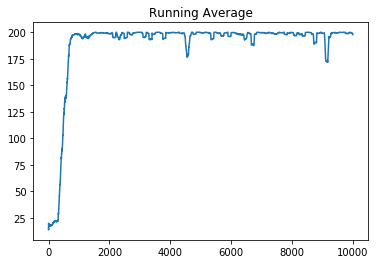

In [11]:
# if __name__ == '__main__':

bins = create_bins()
episode_lengths, episode_rewards = play_many_games(bins)

plot_running_avg(episode_rewards, 100)